# Data Cleaning

1. **Formatting columns**
2. **Explore null values**
3. **Text normalization processing**
4. **Save in csv**

Here I concentrate on the selection of the relevant features of the problem. I explore the distributions of  the null values for each column. In the case of categorical features(string type), I create a normalization process consisting of the correction of spelling errors, elimination of words without information and / or redundant. Finally, I saved the result in a new csv file.

In [1]:
import math 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import re, string, unicodedata
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#from  utilities import convert_to_float,text_to_list,list_to_text,unique_labels
from utilities import *
%matplotlib inline
sns.set()
plt.style.use("ggplot")
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading dataframe
outbreaks = pd.read_excel(open('FoodData.xlsx','rb'), sheet_name=0)

In [3]:
#General information about the dataframe
outbreaks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19986 entries, 0 to 19985
Data columns (total 12 columns):
Year                       19986 non-null int64
Month                      19986 non-null int64
State                      19986 non-null object
Genus Species              13196 non-null object
Serotype or Genotype       4216 non-null object
Etiology Status            13196 non-null object
Location of Preparation    18833 non-null object
Illnesses                  19986 non-null int64
Hospitalizations           16340 non-null float64
Deaths                     16374 non-null float64
Food Vehicle               10500 non-null object
Contaminated Ingredient    2012 non-null object
dtypes: float64(2), int64(3), object(7)
memory usage: 1.8+ MB


In [4]:
outbreaks.head()

,Year,Month,State,Genus Species,Serotype or Genotype,Etiology Status,Location of Preparation,Illnesses,Hospitalizations,Deaths,Food Vehicle,Contaminated Ingredient
0,2009,1,Minnesota,Norovirus,NaN,Suspected,Restaurant - Sit-down dining,2,0.0,0.0,NaN,NaN
1,2009,1,Minnesota,Norovirus,NaN,Confirmed,NaN,16,0.0,0.0,NaN,NaN
2,2009,1,Minnesota,Norovirus,NaN,Suspected,Restaurant - Sit-down dining,5,0.0,0.0,NaN,NaN
3,2009,1,Minnesota,Norovirus,NaN,Confirmed,"Restaurant - ""Fast-food""(drive up service or p...",3,0.0,0.0,NaN,NaN
4,2009,1,Minnesota,Norovirus,NaN,Confirmed,Restaurant - other or unknown type,21,0.0,0.0,cookies,NaN


# Formatting columns <a id='formatting'> </a>

In [5]:
# Renaming columns
outbreaks.columns = ['Year', 'Month', 'State', 'Species', 'Serotype/Genotype',
       'Status', 'Location', 'Illnesses',
       'Hospitalizations', 'Fatalities', 'Food',
       'Ingredient']
 

# Numeric columns to type float
numeric_columns= ['Illnesses', 'Hospitalizations', 'Fatalities']
for column in numeric_columns: 
    outbreaks.loc[:,column]= convert_to_float(outbreaks,column)
    

In [6]:
#In the column Month, each entry  has  a number between  1 and 12. 
#Let us map these numbers  to the name of the months.  

#Renaming column Month to strings 
outbreaks["Month"] =outbreaks.Month.map({1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 
                          7:'July', 8:'August', 9:'September', \
 10:'October', 11:'November', 12:'December'})

In [7]:
outbreaks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19986 entries, 0 to 19985
Data columns (total 12 columns):
Year                 19986 non-null int64
Month                19986 non-null object
State                19986 non-null object
Species              13196 non-null object
Serotype/Genotype    4216 non-null object
Status               13196 non-null object
Location             18833 non-null object
Illnesses            19986 non-null float64
Hospitalizations     16340 non-null float64
Fatalities           16374 non-null float64
Food                 10500 non-null object
Ingredient           2012 non-null object
dtypes: float64(3), int64(1), object(8)
memory usage: 1.8+ MB


Let's substitute the names of the states to their abbreviations.

In [8]:
# By using the dictionary state_abbreviations from utilities.py one can map state name to its abbreviation
State_to_Abbrev = lambda state: state_abbreviations[state] 

state_abrev= outbreaks["State"].apply(State_to_Abbrev)
outbreaks["State"]  = state_abrev
outbreaks.head()

,Year,Month,State,Species,Serotype/Genotype,Status,Location,Illnesses,Hospitalizations,Fatalities,Food,Ingredient
0,2009,January,MN,Norovirus,NaN,Suspected,Restaurant - Sit-down dining,2.0,0.0,0.0,NaN,NaN
1,2009,January,MN,Norovirus,NaN,Confirmed,NaN,16.0,0.0,0.0,NaN,NaN
2,2009,January,MN,Norovirus,NaN,Suspected,Restaurant - Sit-down dining,5.0,0.0,0.0,NaN,NaN
3,2009,January,MN,Norovirus,NaN,Confirmed,"Restaurant - ""Fast-food""(drive up service or p...",3.0,0.0,0.0,NaN,NaN
4,2009,January,MN,Norovirus,NaN,Confirmed,Restaurant - other or unknown type,21.0,0.0,0.0,cookies,NaN


# Null Values <a id='null'> </a>

Let us explore the null values for  each column.

In [9]:
# Sorted list of null values
null_values= outbreaks.isnull().sum().sort_values(axis=0, ascending=True)
# Percent of not null values by column
percent_null_values= 100.0*null_values/outbreaks.shape[0]
percent_not_null_values = round(100.0- percent_null_values)
pd.DataFrame(percent_not_null_values,columns=['Not_null_by_column'])

,Not_null_by_column
Year,100.0
Month,100.0
State,100.0
Illnesses,100.0
Location,94.0
Fatalities,82.0
Hospitalizations,82.0
Species,66.0
Status,66.0
Food,53.0


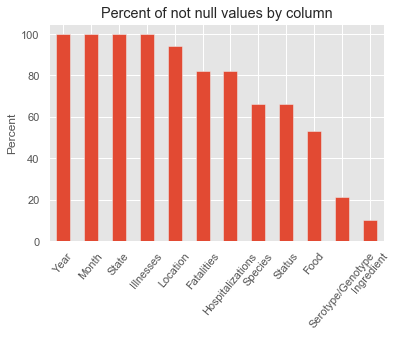

In [10]:
# Plot of not null values by column
percent_not_null_values.plot(kind="bar",rot=50)
plt.title("Percent of not null values by column")
plt.ylabel("Percent")
#plt.xlabel("Column")
plt.show()

Remove columns with many null values($\approx 50 \%$ or more )

In [11]:
# Removing columns: Serotype/Genotype and Ingredient
# Also, let us remove column Status 

outbreaks= outbreaks[['Year', 'Month', 'State', 'Species',
       'Location', "Food",'Illnesses', 'Hospitalizations', 'Fatalities']]

In [12]:
outbreaks.head()

,Year,Month,State,Species,Location,Food,Illnesses,Hospitalizations,Fatalities
0,2009,January,MN,Norovirus,Restaurant - Sit-down dining,NaN,2.0,0.0,0.0
1,2009,January,MN,Norovirus,NaN,NaN,16.0,0.0,0.0
2,2009,January,MN,Norovirus,Restaurant - Sit-down dining,NaN,5.0,0.0,0.0
3,2009,January,MN,Norovirus,"Restaurant - ""Fast-food""(drive up service or p...",NaN,3.0,0.0,0.0
4,2009,January,MN,Norovirus,Restaurant - other or unknown type,cookies,21.0,0.0,0.0


Let's search for hidden white spaces in the categorical columns. When we do a search for a substring in an entry if this  entry is NaN Python give us  an error. To avoid that let us impute a value of type string to the NaN entries. 

In [13]:
categorical_columns = ['Species', 'Location', 'Food']
for column in categorical_columns:
        outbreaks_column= outbreaks[column].fillna("null_value",inplace= False)
        
        outbreaks.loc[:,column] = outbreaks_column
 

# Text processing <a id='text'> </a>
Hidden white spaces.

In [14]:
import re

def extra_spaces(column):# Looking for leading and trailing spaces
    superfluous_spaces=lambda str: True  if re.search(r'^\s+|\s+$', str) else False
    return (outbreaks[column].apply(superfluous_spaces)).sum()


for column in categorical_columns:
    #Trailing
    print("Number of observations with extra spaces in column '{}': {}".format(column,extra_spaces(column)) )



Number of observations with extra spaces in column 'Species': 0
Number of observations with extra spaces in column 'Location': 0
Number of observations with extra spaces in column 'Food': 1


We have a record with extra spaces in the column Food.

In [15]:
# After remove extra spaces in column Food
remove_extra_space = lambda word: word.strip()
outbreaks["Food"] = outbreaks["Food"].apply(remove_extra_space)
print("Number of observations with trailing spaces in Food: {}".format(extra_spaces("Food") )) 

Number of observations with trailing spaces in Food: 0


An outbreak can happen in different locations and/or can be caused by several types of food at the same time. 
Also, it can be caused by multiple species. In our dataset these records with multiple entries are separated by semicolons. Let us check the spaces around these semicolons. The spaces after the semicolons are syntactically correct, but the  spaces before are errors.

In [16]:

# Any space before of after the ;
print("For categorical columns, do all semicolons contain an space after?")
print('')
for column in categorical_columns:
    print("For {} -> {}.".format(column,(outbreaks[column].str.contains(r";")).sum() \
    ==(outbreaks[column].str.contains(r";\s")).sum()))
print('')
print("For categorical columns, do all semicolons contain an space before?")
print('')
for column in categorical_columns:
    print("For {} -> {}.".format(column,(outbreaks[column].str.contains(";")).sum() \
    ==(outbreaks[column].str.contains(r"\s;")).sum()))

For categorical columns, do all semicolons contain an space after?

For Species -> True.
For Location -> True.
For Food -> True.

For categorical columns, do all semicolons contain an space before?

For Species -> False.
For Location -> False.
For Food -> False.


It can happen that two records contain the same elements but arranged in a different way. To avoid counting these records as different let us sort each record.

In [17]:
outbreaks.loc[:,'Location']=list_to_text(text_to_list(outbreaks,'Location'))


In [18]:
# Extracting unique values(using unique_labels from utilities.py)
unique_labels(text_to_list(outbreaks,'Location'))

['banquet facility (food prepared and served on-site)',
 'camp',
 'caterer (food prepared off-site from where served)',
 'child day care',
 'fair, festival, other temp or mobile services',
 'farm/dairy',
 'grocery store',
 'hospital',
 'hotel/motel',
 'long-term care/nursing home/as...',
 'long-term care/nursing home/assisted living facility',
 'null_value',
 'office/indoor workplace',
 'other',
 'prison/jail',
 'private home/residence',
 'religious facility',
 'restaurant - "fast-food"(drive up service or pay at counter)',
 'restaurant - buffet',
 'restaurant - other or unknown type',
 'restaurant - sit-down dining',
 'school/college/university',
 'ship/boat',
 'unknown']

Here we have: two locations named: long-term care/nursing home/assisted living facility' and long-term care/nursing home/as...', but they are the same place. 

In [19]:
# row that contains 'long-term care/nursing home/as...'
long_term_diff_sintaxis=outbreaks.Location[outbreaks.Location.str.contains(r'long-term care/nursing home/as\.\.\.')]
print(list(long_term_diff_sintaxis))

['grocery store; long-term care/nursing home/as...; private home/residence; restaurant - "fast-food"(drive up service or pay at counter); restaurant - other or unknown type; restaurant - sit-down dining']


In [20]:
outbreaks.Location[long_term_diff_sintaxis.index[0]]='restaurant - "fast-food"(drive up service or pay at counter); restaurant - sit-down dining; restaurant - other or unknown type; private home/residence; grocery store; long-term care/nursing home/assisted living facility'

unique_labels(text_to_list(outbreaks,'Location'))

['banquet facility (food prepared and served on-site)',
 'camp',
 'caterer (food prepared off-site from where served)',
 'child day care',
 'fair, festival, other temp or mobile services',
 'farm/dairy',
 'grocery store',
 'hospital',
 'hotel/motel',
 'long-term care/nursing home/assisted living facility',
 'null_value',
 'office/indoor workplace',
 'other',
 'prison/jail',
 'private home/residence',
 'religious facility',
 'restaurant - "fast-food"(drive up service or pay at counter)',
 'restaurant - buffet',
 'restaurant - other or unknown type',
 'restaurant - sit-down dining',
 'school/college/university',
 'ship/boat',
 'unknown']

In [21]:
# Species column
outbreaks.loc[:,'Species']=list_to_text(text_to_list(outbreaks,'Species'))

There are words in the column Species such as 'other' and 'unknown' which are uninformative. But as there is a category named as Other, we have to procced in several steps. 


In [22]:
# Remove patterns ', other' and  ' unknown'
outbreaks.loc[:,'Species']=outbreaks.Species.str.replace(r', other','').str.replace(r' unknown','')

In [23]:
unique_labels(text_to_list(outbreaks,'Species'))[:25]

['adenovirus',
 'amnesic shellfish poison',
 'anisakis',
 'astrovirus',
 'bacillus',
 'bacillus cereus',
 'bacillus other',
 'brucella',
 'campylobacter',
 'campylobacter coli',
 'campylobacter fetus',
 'campylobacter jejuni',
 'campylobacter other',
 'ciguatoxin',
 'cleaning agents',
 'clostridium botulinum',
 'clostridium other',
 'clostridium perfringens',
 'cryptosporidium',
 'cryptosporidium hominis',
 'cryptosporidium parvum',
 'cyclospora',
 'cyclospora cayetanensis',
 'enterobacter cloacae',
 'enterobacter other']

To remove ' other' first we need to change '; other' to something else, then remove ' other' and then put '; other' back.

In [24]:
outbreaks.loc[:,'Species']=outbreaks.Species.str.replace(r'; other','; temporal_other')
outbreaks.loc[:,'Species']=outbreaks.Species.str.replace(r' other','')
outbreaks.loc[:,'Species']=outbreaks.Species.str.replace(r'; temporal_other',r'; other')

In [25]:
unique_labels(text_to_list(outbreaks,'Species'))[:25]

['adenovirus',
 'amnesic shellfish poison',
 'anisakis',
 'astrovirus',
 'bacillus',
 'bacillus cereus',
 'brucella',
 'campylobacter',
 'campylobacter coli',
 'campylobacter fetus',
 'campylobacter jejuni',
 'ciguatoxin',
 'cleaning agents',
 'clostridium',
 'clostridium botulinum',
 'clostridium perfringens',
 'cryptosporidium',
 'cryptosporidium hominis',
 'cryptosporidium parvum',
 'cyclospora',
 'cyclospora cayetanensis',
 'enterobacter',
 'enterobacter cloacae',
 'enterococcus faecalis',
 'escherichia coli']

In [26]:
# Removing Palau
outbreaks= outbreaks.loc[outbreaks.State!="PW",:]
#outbreaks= outbreaks.reset_index()
outbreaks.head()

,Year,Month,State,Species,Location,Food,Illnesses,Hospitalizations,Fatalities
0,2009,January,MN,norovirus,restaurant - sit-down dining,null_value,2.0,0.0,0.0
1,2009,January,MN,norovirus,null_value,null_value,16.0,0.0,0.0
2,2009,January,MN,norovirus,restaurant - sit-down dining,null_value,5.0,0.0,0.0
3,2009,January,MN,norovirus,"restaurant - ""fast-food""(drive up service or p...",null_value,3.0,0.0,0.0
4,2009,January,MN,norovirus,restaurant - other or unknown type,cookies,21.0,0.0,0.0


In [27]:
# Food column

outbreaks.loc[:,'Food']=list_to_text(text_to_list(outbreaks,'Food'))

In [28]:
food_labels=unique_labels(text_to_list(outbreaks,'Food'))
food_labels[:10]

['acai, bananas, strawberries, sugar cane juice',
 'ackawi cheese, pasteurized',
 'alboacore tuna',
 'alcohol',
 'alfalfa seeds',
 'alfalfa sprouts',
 'alfredo sauce',
 'alligator',
 'ambrosia',
 'american cheese, pasteurized']

In [29]:
print('Number of food labels: {}.'.format(len(food_labels)))

Number of food labels: 1791.


Let us check some words in the food sources that are uninformative, i.e. 
unknown, source unknown, unspecified and  other.

In [30]:

def count_word(dataframe,column, word):
    # Count how many times word appears in a column
    
    #Params:
    # dataframe is the dataframe
    # column is the column of interest 
    # word to look for
    
    # Return:
    # Integer with the numer of times that word appears in a column
    
    return len(dataframe[column][dataframe[column].str.contains(word)])


In [31]:
list_uninformative_words= ['source unknown', 'unknown','unspecified','other']
for word in list_uninformative_words:
    print('Count of {} is {}'.format(word,count_word(outbreaks,'Food', word)))

Count of source unknown is 3
Count of unknown is 26
Count of unspecified is 3297
Count of other is 558


In [32]:
for word in list_uninformative_words:
    outbreaks.loc[:,'Food']=outbreaks.Food.str.replace(word,'')

Correct some misspelling

In [33]:
misspelling_words={'antipasta':'antipasto','beef(fresly killed cow), raw and/or undercooked':'beef, raw','stronganoff':'stroganoff','fettucine':'fettuccine'}

In [34]:
for word_key in  misspelling_words.keys():
    outbreaks.loc[:,'Food']=outbreaks.Food.str.replace(word_key,misspelling_words[word_key])


Normalizing food column.

In [35]:
#Normalizing food column.

tokenized_column_food=outbreaks.Food.apply(lambda entry: word_tokenize(entry))
tokenized_column_food[:10]

0                              [null_value]
1                              [null_value]
2                              [null_value]
3                              [null_value]
4                                 [cookies]
5                                [salad, ,]
6                              [null_value]
7    [fruit, ;, mushrooms, ;, pasta, salad]
8                              [vegetables]
9                              [lettuce, ,]
Name: Food, dtype: object

In [36]:
# normalized_column_food is a column where each entry is a list of words(normalized)
normalized_column_food=tokenized_column_food.apply(lambda entry: normalize(entry))
# First 10 elements
normalized_column_food[:10] 

0                        [nullvalue]
1                        [nullvalue]
2                        [nullvalue]
3                        [nullvalue]
4                            [cooky]
5                            [salad]
6                        [nullvalue]
7    [fruit, mushroom, pasta, salad]
8                        [vegetable]
9                          [lettuce]
Name: Food, dtype: object

In [37]:
# Transforming each entry of normalized_column_food from list to strings
outbreaks['normalized_food']=normalized_column_food.apply(lambda list_words: " ".join(list_words))
# Replacing nullvalue by null_value
outbreaks['normalized_food']=outbreaks['normalized_food'].str.replace(r'nullvalue','null_value')
outbreaks.tail()

,Year,Month,State,Species,Location,Food,Illnesses,Hospitalizations,Fatalities,normalized_food
19981,2016,November,CA,salmonella enterica,restaurant - sit-down dining,null_value,18.0,3.0,0.0,null_value
19982,2016,May,CA,campylobacter jejuni,restaurant - sit-down dining,null_value,60.0,3.0,0.0,null_value
19983,2016,April,MUL_STATE,salmonella enterica,restaurant - sit-down dining,shell eggs,8.0,2.0,0.0,shell egg
19984,2016,October,MUL_STATE,"escherichia coli, shiga toxin-producing",null_value,null_value,13.0,10.0,1.0,null_value
19985,2016,April,MUL_STATE,"escherichia coli, shiga toxin-producing",null_value,null_value,4.0,0.0,0.0,null_value


In [38]:
# Returning 'null_value' back to NaN
outbreaks.replace('null_value',np.NaN,inplace=True)
# Last outbreaks
outbreaks.tail()

,Year,Month,State,Species,Location,Food,Illnesses,Hospitalizations,Fatalities,normalized_food
19981,2016,November,CA,salmonella enterica,restaurant - sit-down dining,NaN,18.0,3.0,0.0,NaN
19982,2016,May,CA,campylobacter jejuni,restaurant - sit-down dining,NaN,60.0,3.0,0.0,NaN
19983,2016,April,MUL_STATE,salmonella enterica,restaurant - sit-down dining,shell eggs,8.0,2.0,0.0,shell egg
19984,2016,October,MUL_STATE,"escherichia coli, shiga toxin-producing",NaN,NaN,13.0,10.0,1.0,NaN
19985,2016,April,MUL_STATE,"escherichia coli, shiga toxin-producing",NaN,NaN,4.0,0.0,0.0,NaN


In [39]:
outbreaks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19984 entries, 0 to 19985
Data columns (total 10 columns):
Year                19984 non-null int64
Month               19984 non-null object
State               19984 non-null object
Species             13195 non-null object
Location            18831 non-null object
Food                10499 non-null object
Illnesses           19984 non-null float64
Hospitalizations    16338 non-null float64
Fatalities          16372 non-null float64
normalized_food     10499 non-null object
dtypes: float64(3), int64(1), object(6)
memory usage: 1.7+ MB


In [40]:
# Save the clean dataset
outbreaks.to_csv('cleaned_outbreaks.csv',index=False) 